# Labeled Convolutional VAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'vae.conv.labeled'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 75
LR = 4e-04
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222
hidden_dims = (128, 64, 32)
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92

model = M.vae.LabeledConvVAE(input_dim, hidden_dims, latent_dim, classes_dim)
criterion = M.vae.Loss()

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)


INFO | model: pallets.models.vae.LabeledConvVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.0004
INFO | epochs: 75
INFO | epoch 1 (  0%) loss: 1418881.875000
INFO | epoch 1 ( 35%) loss: 147907.664565
INFO | epoch 1 ( 70%) loss: 82973.755087
INFO | epoch 1 (100%) loss: 63200.006926
INFO | epoch 1 (test) loss: 13622.072990
INFO | epoch 2 (  0%) loss: 13719.016602
INFO | epoch 2 ( 35%) loss: 13501.921014
INFO | epoch 2 ( 70%) loss: 13208.586176
INFO | epoch 2 (100%) loss: 12905.308672
INFO | epoch 2 (test) loss: 11992.284554
INFO | epoch 3 (  0%) loss: 12913.193359
INFO | epoch 3 ( 35%) loss: 11993.850567
INFO | epoch 3 ( 70%) loss: 11801.122493
INFO | epoch 3 (100%) loss: 11602.426234
INFO | epoch 3 (test) loss: 10929.925522
INFO | epoch 4 (  0%) loss: 10738.251953
INFO | epoch 4 ( 35%) loss: 10962.986454
INFO | epoch 4 ( 70%) loss: 10672.250593
INFO | epoch 4 (100%) loss: 10463.316593
INFO | epoch 4 (test) loss: 9564.837967
INFO | epoch 5 (  0%) loss: 9278.004883
INFO

# Results

torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


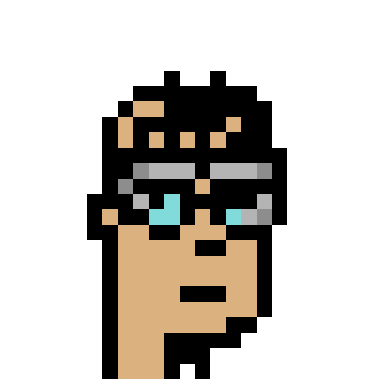

In [9]:

z = torch.randn(1, latent_dim).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)

decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


In [10]:
import random

label_idx = int(random.random() * len(dataset))
_, features = dataset[label_idx]

enabled_features = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['male', 'luxuriousBeard', 'headband', 'regularShades', 'cigarette']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


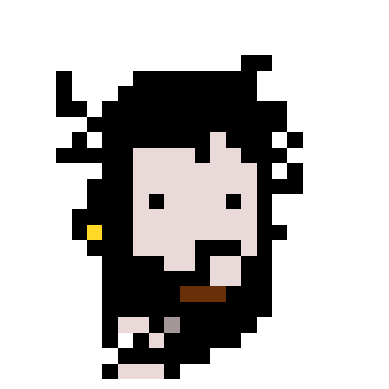

In [11]:
# Generate new image

z = torch.randn(1, latent_dim).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)

decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


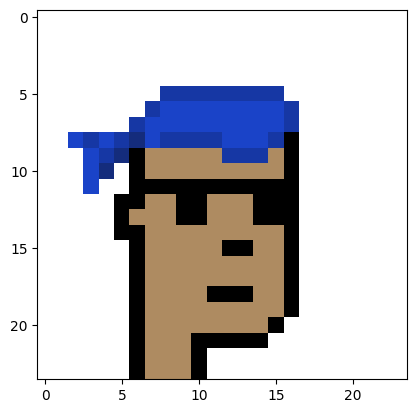

In [12]:
# punk = I.get_punk_tensor(1000)
punk, punk_labels = dataset[4000]
punk = DS.one_hot_to_rgba(punk, dataset.mapper)

plt.imshow(transforms.functional.to_pil_image(punk))
plt.show()



torch.Size([1, 222, 24, 24])


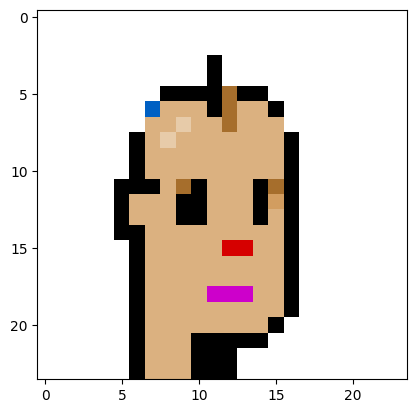

In [13]:
punk, punk_labels = dataset[4000]

punk_labels = punk_labels.unsqueeze(0).to(device)

# punk = I.get_punk_tensor(1000)

p = DS.rgba_to_one_hot(punk, dataset.mapper)
p = p.unsqueeze(0)
p = p.to(device)

model.eval()
with torch.no_grad():
    reconstructed, mu, logcar = model.forward(p, punk_labels)
    print(reconstructed.shape)

recon_punk = reconstructed[0].cpu()
recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)
plt.imshow(transforms.functional.to_pil_image(recon_punk.cpu()))
plt.show()


## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

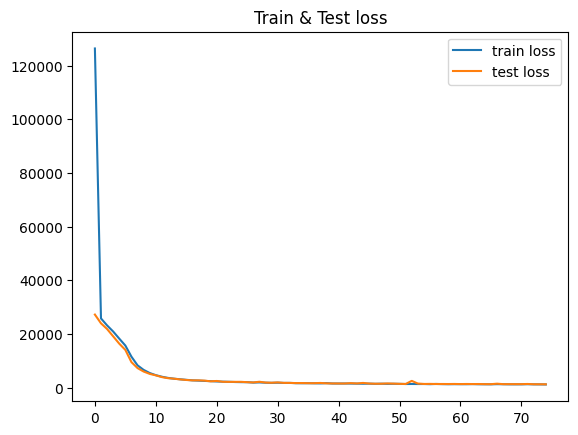

In [14]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [15]:
train_losses


[126400.01385195035,
 25810.61734333444,
 23204.852468071254,
 20926.63318650266,
 18272.663631358046,
 15692.802554299646,
 11543.852951158024,
 8320.185749892647,
 6621.651414803579,
 5455.567600547844,
 4660.351126163564,
 4075.3913357782026,
 3642.6466467025434,
 3345.6846322134033,
 3127.9865177235706,
 2925.6908902648493,
 2729.852454219304,
 2625.175141463043,
 2521.5016702422013,
 2422.0332228207417,
 2312.199836460411,
 2235.9934460795516,
 2187.0456460722794,
 2108.796550777787,
 2060.48621049164,
 2049.1967957408715,
 1893.8371636140432,
 1962.5627242284463,
 1852.505905043149,
 1803.4049284373614,
 1853.6087374856286,
 1779.188554587939,
 1780.2621037909325,
 1672.9035391300283,
 1650.4666868169256,
 1668.3182005104443,
 1630.8724479945838,
 1591.6662203741412,
 1691.1940272987313,
 1553.168525425255,
 1547.9314370662607,
 1554.8004035679162,
 1534.5750008441032,
 1505.7171542120318,
 1476.812113011137,
 1500.6356989001551,
 1436.0232644588389,
 1479.2718653036347,
 1421.27

In [16]:
test_losses


[27244.14598083496,
 23984.569107055664,
 21859.851043701172,
 19129.67593383789,
 16400.405639648438,
 14072.878913879395,
 9510.974994659424,
 7296.9016189575195,
 6012.903888702393,
 5141.010417938232,
 4596.934803009033,
 3937.816904067993,
 3541.888885498047,
 3345.162775039673,
 3078.0821418762207,
 2870.9047355651855,
 2725.7355003356934,
 2726.6451110839844,
 2627.5663166046143,
 2365.555150985718,
 2494.353759765625,
 2200.256275177002,
 2165.250831604004,
 2169.473949432373,
 2176.9516925811768,
 2041.1919136047363,
 1955.4635467529297,
 2202.308524131775,
 1906.637321472168,
 1840.6927070617676,
 1963.8975992202759,
 1788.2384147644043,
 1781.9321975708008,
 1713.103910446167,
 1723.3261966705322,
 1671.6449890136719,
 1672.2619733810425,
 1757.8297939300537,
 1615.5542526245117,
 1576.7026224136353,
 1560.6155519485474,
 1554.5318183898926,
 1688.9262895584106,
 1569.6641788482666,
 1768.4698600769043,
 1543.6919498443604,
 1469.4569854736328,
 1475.4719610214233,
 1580.091